In [1]:
import os
from shutil import copy

import numpy as np
import pandas as pd

In [2]:
DATASET_FOLDERS = ["data/75k_balanced", "data/extra_turn_data", "data/too_far_left", "data/too_far_right"]
DATASET_STEERING_BIASES = [0, 0, 0.2, -0.2]
NEW_FOLDER_PATH = "data/combined_datasets"

In [3]:
root_path = os.path.dirname(os.path.dirname(os.getcwd()))

new_folder_path = os.path.join(root_path, NEW_FOLDER_PATH)
new_vehicle_data_file_path = os.path.join(new_folder_path, "VehicleData.txt")
new_image_folder_path = os.path.join(new_folder_path, "IMG")

os.makedirs(new_folder_path)
os.makedirs(new_image_folder_path)

In [4]:
combined_data = []

current_index = 0
for dataset_index, folder_path in enumerate(DATASET_FOLDERS):
    data_folder_path = os.path.join(root_path, folder_path)
    vehicle_data_file_path = os.path.join(data_folder_path, "VehicleData.txt")

    current_df = pd.read_csv(vehicle_data_file_path, sep=" ", header=None,
                             names=["image_path", "throttle", "break", "steering_angle", "velocity"])

    current_df["steering_angle"] = (2 * (current_df["steering_angle"] - current_df["steering_angle"].min()) / (
            current_df["steering_angle"].max() - current_df["steering_angle"].min())) - 1
    current_df["steering_angle"] += DATASET_STEERING_BIASES[dataset_index]
    current_df["steering_angle"] = current_df["steering_angle"].clip(lower=-1, upper=1)

    new_image_paths = []
    indices_to_skip = []
    for index, row in current_df.iterrows():
        old_image_path = row.image_path[1:]
        source_image_folder_path = os.path.join(data_folder_path, old_image_path)  # image_path starts with '/'
        if not os.path.exists(source_image_folder_path):
            indices_to_skip.append(index)
            continue

        new_image_path = os.path.join("IMG", f"CapturedImage_{current_index}.jpg")
        new_image_paths.append(f"/{new_image_path}")
        current_index += 1
        destination_image_folder_path = os.path.join(new_folder_path, new_image_path)
        copy(source_image_folder_path, destination_image_folder_path)

    current_df = current_df.drop(indices_to_skip)
    current_df["image_path"] = new_image_paths

    combined_data.append(current_df)

In [5]:
df = pd.concat(combined_data)
with open(new_vehicle_data_file_path, "w+") as file:
    np.savetxt(file, df.values, fmt="%s")

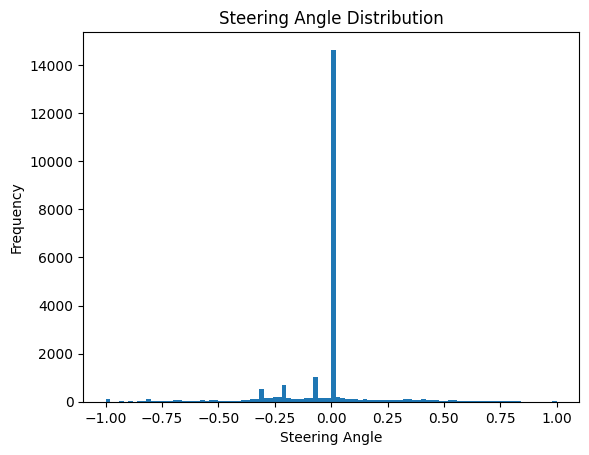

In [6]:
import matplotlib.pyplot as plt

plt.hist(df["steering_angle"], bins=100)
plt.title("Steering Angle Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Frequency")
plt.show()

In [7]:
df.describe()

,throttle,break,steering_angle,velocity
count,23014.000000,23014.000000,23014.000000,2966.000000
mean,1798.958809,6562.826155,-0.025149,30.574967
std,1642.466030,9279.888017,0.218109,1.182359
min,0.054902,0.000000,-1.000000,29.359194
25%,42.329118,0.000000,0.004111,30.160274
50%,1435.338500,0.000000,0.010239,30.370341
75%,3599.998000,20000.000000,0.010264,30.631230
max,3600.000000,20000.000000,1.000000,40.940531
